### Proyecto de mentoría
### Herramientas de Data Science para dosimetría en medicina nuclear
### Facilitador: P. Pérez

### Proyecto de mentoría para la materia de Análisis exploratorio y curación de datos.
### Herramientas de Data Science para dosimetría en medicina nuclear.

# Análisis exploratorio y curación de datos

Se buscará realizar un análisis exploratorio de los datos de un dataset, considerando el dataset como una serie de imágenes médicas de un mismo paciente durante un mismo tratamiento/procedimiento.

En el presente proyecto realizaremos un trabajo de exploración sobre un conjunto de imágenes tratadas en la materia anterior. Cada imagen constituirá un dataset en sí mismo.
Dataset

### Consideraciones generales

Los datasets deben corresponder a imágenes de medicina nuclear, es decir, obtenidas a partir de la detección de fotones provenientes de emisión de radionucleidos previamente suministrados a un paciente.

Los datasets deben encontrarse anonimizados y pertenecer, o bien a una base de datos pública para educación/investigación o a una clínica médica que las otorgue anonimizadas y con consentimiento escrito para estos fines (recomendable a los fines de poder contar con imágenes para el resto de las materias y poder discutir el dataset con quien las provéa, generalmente interesado/a en un estudio de estas características).
Consignas

**1) Realice un análisis exploratorio sobre cada dataset.**

**2) Defina la elección del dataset y describa el mismo a partir de un análisis exploratorio que considere pertinente.**

**3) Clasifique los valores del dataset según su valor.**

**4) Visualice los datos e identifique posibles clústers por diferentes métodos de clustering.**

**5) Encuentre cúmulos y visualice los encontrados.**

**6) Realice una interpretación de los K cúmulos encontrados a partir del conocimiento del tipo de dataset utilizado.**

**7) Realice una limpieza de los datos que considere oportuna de acuerdo al conocimiento del campo específico del dataset.**

**8) ¿Encuentra alguna relación específica entre los cúmulos encontrados y algún parámetro importante para el estudio y análisis del dataset? En caso de responder positivamente, desarrolle.**


### Los puntos 1, 2, 3 y 7, ya han sido realizados en el trabajo práctico número 1. 
#### En particular en el punto 7, en el trabajo previo se buscó alguna etrategia para determinar la presencia de ruido y se trabajó con los outliers. 
#### Se identificó que había pixels en el fondo que tenían un valor de intensidad distinto de cero, es decir que hay un posible ruido de fondo por problemas de colimación. A partir de esto, se puede prever la presencia de valores de intensidad corruptos por este fenómeno también en el interior de la region 'cuerpo'. Sin embargo, como no se podría saber de antemano qué pixeles son los afectados y como tampoco sería correcto restarle a la totalidad de la imagen un promedio de las intensidades de los pixeles identificados como defectuosos en el fondo (ya que en aquellos casos en donde tuvieran la intesidad correcta se los estaría alterando); se decide no avanzar en la limpieza de este defecto.

## 4) Visualice los datos e identifique posibles clústers por diferentes métodos de clustering.

In [1]:
%matplotlib inline

import os
import cv2
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 
import pydicom as dicom
import matplotlib as mpl
import numpy.matlib

from scipy import linalg
from sklearn import mixture

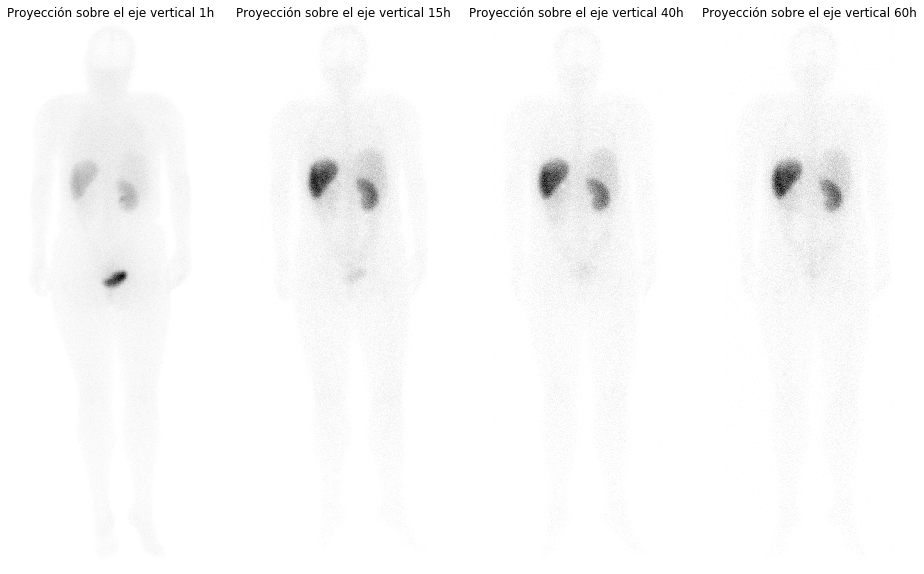

In [47]:
# Definimos el path en donde están las imágenes:
BASE='./Imágenes Pedro'
path_1hr = (BASE + '/1h')
path_15hr = (BASE +'/15h')
path_40hr = (BASE +'/40h')
path_64hr = (BASE +'/64h')

# Enlistamos y ordenamos los archivos dicom de cada carpeta
imgs_1hr = os.listdir(path_1hr)
imgs_15hr = os.listdir(path_15hr)
imgs_40hr = os.listdir(path_40hr)
imgs_64hr = os.listdir(path_64hr)

imgs_1hr.sort()
imgs_15hr.sort()
imgs_40hr.sort()
imgs_64hr.sort()

# Cargamos las imágenes de cada tiempo (sólo se usan las post_sc.dcm, que nos parecieron las mejores):
img1_dcm =  dicom.read_file(path_1hr + '/' + imgs_1hr[2])
img1 = img1_dcm.pixel_array

img2_dcm =  dicom.read_file(path_15hr + '/' + imgs_15hr[2])
img2 = img2_dcm.pixel_array

img3_dcm =  dicom.read_file(path_40hr + '/' + imgs_40hr[2])
img3 = img3_dcm.pixel_array

img4_dcm =  dicom.read_file(path_64hr + '/' + imgs_64hr[2])
img4 = img4_dcm.pixel_array

# Buscamos el máximo para normalizar las cuentas a travez de los tiempos (ver la atenuación que se produce)
# Se genera un vector con el máximo de cada imagen en cada elemento
imax= [np.max(img1),np.max(img2),np.max(img3),np.max(img4)]
imin= [np.min(img1),np.min(img2),np.min(img3),np.min(img4)]

# Graficamos las imágenes resultantes:
img1 = img1[75:860,:]
img2 = img2[80:865,:]
img3 = img3[100:885,:]
img4 = img4[100:885,:]

imax= [np.max(img1),np.max(img2),np.max(img3),np.max(img4)]
imin= [np.min(img1),np.min(img2),np.min(img3),np.min(img4)]

plt.figure(figsize=(16,10))

plt.subplot(141)
plt.title('Proyección sobre el eje vertical 1h')
plt.imshow(imax[0]-img1, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(142)
plt.title('Proyección sobre el eje vertical 15h')
plt.imshow(imax[1]-img2, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(143)
plt.title('Proyección sobre el eje vertical 40h')
plt.imshow(imax[2]-img3, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(144)
plt.title('Proyección sobre el eje vertical 60h')
plt.imshow(imax[3]-img4, cmap=plt.cm.gray)
plt.axis('off')

plt.show()

# Separamos la imagen en 4 categorías constituyentes: Fondo, Cuerpo, Órganos target del radiofármaco, Vejiga.
fondo = img1.copy()
cuerpo = img1.copy()
organos = img1.copy()
vejiga = img1.copy()

fondo[fondo<7] = 1  
fondo[fondo>=7] = 0

cuerpo[cuerpo<7] = 0
cuerpo[cuerpo>75] = 0
cuerpo[cuerpo!=0] = 1

organos[organos<75] = 0
organos[organos>=75] = 1
vejiga = organos.copy()
organo1 = organos.copy()
organo2 = organos.copy()
organo1[300:,:] = 0
organo1[:,120:] = 0
organo2[300:,:] = 0
organo2[:,0:120] = 0
vejiga[0:300,:] = 0

# Para dejar regiones más simples segmentadas, se realizan opraciones de cierre y apertura. 
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
fondo = cv2.morphologyEx(fondo, cv2.MORPH_OPEN, kernel)
organo1 = cv2.morphologyEx(organo1, cv2.MORPH_OPEN, kernel)
organo2 = cv2.morphologyEx(organo2, cv2.MORPH_OPEN, kernel)
cuerpo = cv2.morphologyEx(cuerpo, cv2.MORPH_CLOSE, kernel)
vejiga = cv2.morphologyEx(vejiga, cv2.MORPH_OPEN, kernel)

# Creamos máscaras lógicas de cada región
m1 = fondo>0
m2 = cuerpo>0
m3 = organo1>0
m4 = organo2>0
m5 = vejiga>0

# Creamos una sola imagen que contiene las etiquetas de cada región:
labels = cuerpo.copy()*1;
labels[m3]=2;
labels[m4]=3;
labels[m5]=4;

# Para aplicar conceptos vistos en la materia y facilitar calculos posteriores 
# se transformaron las imágenes a un pandas Data Frame

s=np.shape(img1)                  # Generamos un vector de longitud igual al largo de la imagen (número de filas), 
a=np.asarray(np.arange(0,s[0],1)) # cuyos elementos van de cero al número de filas
a=np.matlib.repmat(a,s[1],1)      # repetimos el vector a lo largo de las columnas, es decir tengo que cada 
                                  # elemento contiene el número de fila que posee
a=np.transpose(a)                 
y=a.flatten()                     # lo llevo a un vector, que tiene los números de fila de cada elemento

b=np.asarray(np.arange(0,s[1],1)) # Igual al caso anterior pero con las columnas
b=np.matlib.repmat(b,s[0],1)
x=b.flatten()

label_flat=labels.flatten()       # Un vector con la etiqueta ed cada elemento
int1_flat=img1.flatten()          # Un vector por intensidad en cada tiempo
int2_flat=img2.flatten()
int3_flat=img3.flatten()
int4_flat=img4.flatten()
l=np.shape(int1_flat)
tiempo=np.zeros(l[0])
tiempo1=tiempo+1                  # Vector de ceros que luego va a tener cada uno de los 4 tiempos
tiempo2=tiempo+15
tiempo3=tiempo+40
tiempo4=tiempo+60

# Definimos un primer juego de Data Frames por imagen:
Dosis_1=pd.DataFrame(columns=['x','y','Intensidad','Etiqueta','Tiempo'])
Dosis_1['x']=x
Dosis_1['y']=y
Dosis_1['Intensidad']=int1_flat
Dosis_1['Etiqueta']=label_flat
Dosis_1['Tiempo']=tiempo1

Dosis_2=pd.DataFrame(columns=['x','y','Intensidad','Etiqueta','Tiempo'])
Dosis_2['x']=x
Dosis_2['y']=y
Dosis_2['Intensidad']=int2_flat
Dosis_2['Etiqueta']=label_flat
Dosis_2['Tiempo']=tiempo2

Dosis_3=pd.DataFrame(columns=['x','y','Intensidad','Etiqueta','Tiempo'])
Dosis_3['x']=x
Dosis_3['y']=y
Dosis_3['Intensidad']=int3_flat
Dosis_3['Etiqueta']=label_flat
Dosis_3['Tiempo']=tiempo3

Dosis_4=pd.DataFrame(columns=['x','y','Intensidad','Etiqueta','Tiempo'])
Dosis_4['x']=x
Dosis_4['y']=y
Dosis_4['Intensidad']=int4_flat
Dosis_4['Etiqueta']=label_flat
Dosis_4['Tiempo']=tiempo4

# Diccionario para llevar las labels de números a strings
d={0: 'fondo',1: 'cuerpo',2: 'organo1',3: 'organo2',4: 'vejiga'}

#Concatenamos los Data Frames
frames = [Dosis_1,Dosis_2,Dosis_3,Dosis_4]
Dosis = pd.concat(frames)
Dosis =Dosis.replace({"Etiqueta": d})

#Guardamos el DataFrame o lo cargamos:
Dosis.to_pickle('Dosis_database_tp2')
#Dosis = pd.read_pickle('Dosis_database_b')

#### Para comenzar, se trabaja con la imagen correspondiete a la hora de inyectado el radiofármaco y se buscan los clusters presentes. Se decide optar por el algoritmo de Expectation Maximization, que a su vez inicializa las medias por medio de k-means.

Se toman para cada pixel las coordenadas x,y y intensidad como features, así se puede evaluar la información de intensidad al mismo tiempo que la información espacial. 

In [10]:
cuerpo = (Dosis.Tiempo==1)&((Dosis.Etiqueta=='cuerpo')|(Dosis.Etiqueta=='organo1')|(Dosis.Etiqueta=='organo2')|(Dosis.Etiqueta=='vejiga'))
i1 = (Dosis.Tiempo==1)
X = Dosis.loc[i1,'x':'Intensidad'].values

Initialization 0
Initialization converged: True
Initialization 0
  Iteration 10
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
  Iteration 50
Initialization converged: True
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
Initialization converged: True
Initialization 0
  Iteration 10
  Ite

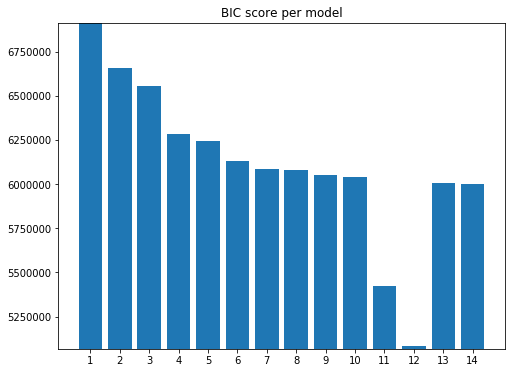

In [11]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)

for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components = n_components,
                                  covariance_type = 'full', 
                                  max_iter=100, 
                                  init_params='kmeans',
                                  random_state=0)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
        
bic = np.array(bic)

clf = best_gmm

bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
plt.bar(x=n_components_range, height=bic)
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
plt.ylabel('BIC value')
plt.xlabel('N° of gaussians')

plt.show()


De acuerdo a Bayesian Information Criterion, deberíamos elegir un modelo con 12 gaussianas:

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


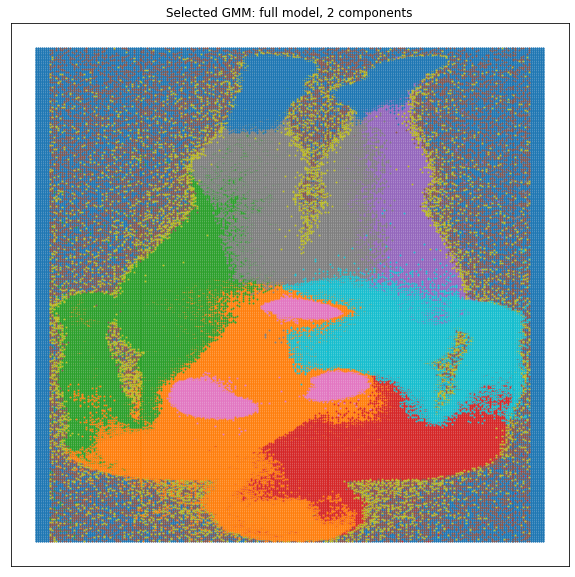

In [15]:
clf = mixture.GaussianMixture(n_components=12,
                              covariance_type = 'full', 
                              init_params='kmeans',
                              random_state=0)
Y_=clf.fit_predict(X)

# Plot the winner
plt.figure(figsize=(10,10))

for i in np.unique(Y_.astype('int')):
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, cmap=plt.get_cmap('Set3'))
    
plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.show()

Vemos que si bien identifica regiones en forma correcta, se generan más clusters de los que podríamos pensar que son necesarios. Ejemplo de esto son las regiones verde, celeste, naranja, rojo. También se ve que los pies son identificados como fondo, lo que claramente es un error.

Se prueba con menos clusters. Si vemos el gráfico de bic, hay un cambio brusco en el valor desde 3 a 4 clusters y a continuación se mantiene más o menos constante hasta 11 clusters. Por esto probamos con 4:





Initialization 0
  Iteration 10
  Iteration 20
Initialization converged: True


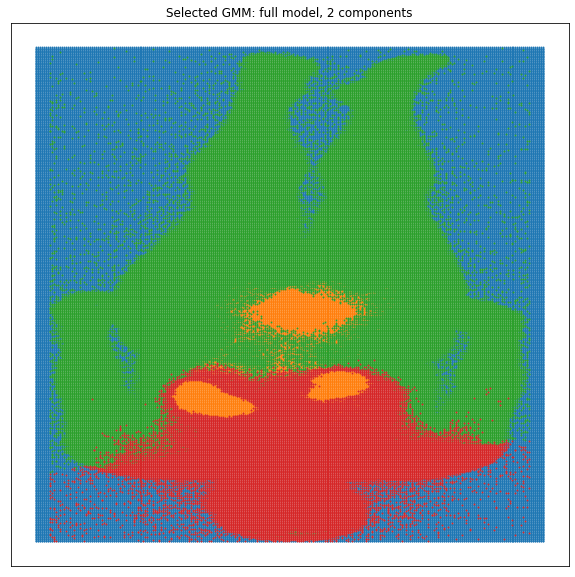

In [16]:
clf = mixture.GaussianMixture(n_components=4,
                              covariance_type = 'full', 
                              init_params='kmeans',
                              random_state=0)
Y_=clf.fit_predict(X)

# Plot the winner
plt.figure(figsize=(10,10))

for i in np.unique(Y_.astype('int')):
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, cmap=plt.get_cmap('Set3'))

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.show()

Se pude ver cómo la imagen generada es mucho más consecuente con la regiones identificadas en el trabajo práctico anterior. Se puede ver cómo hay pixels en el fondo que son identificados como cuerpo, lo que coincide con los outliers identificados en el trabajo anterior.

Luego la diferencia entre el cluster rojo y verde, nosotros no la habíamos identificado, pero puede tener que ver con la influencia de los órganos (en conjunto con ese pequeño defecto de colimación) que hace que en los alrededores de éllos suba el nivel de intensidad y así se los identifique como un nuevo grupo.

Por último los órganos blanco del radiofármaco, son identificados en forma coincidente con lo hecho en el práctico anterior. Quizás la vejiga es identificada con dimensiones mayores.

#### Para mejorar los resultados se decide usar un abordaje mixto, se aprovechan las máscaras generadas en el trabajo previo y de aplica el algoritmo de mixtura de gaussianas a la porción de la imagen que no se identificó como fondo.

In [18]:
cuerpo = (Dosis.Tiempo==1)&((Dosis.Etiqueta=='cuerpo')|(Dosis.Etiqueta=='organo1')|(Dosis.Etiqueta=='organo2')|(Dosis.Etiqueta=='vejiga'))
i1 = (Dosis.Tiempo==1)
X = Dosis.loc[cuerpo,'x':'Intensidad'].values

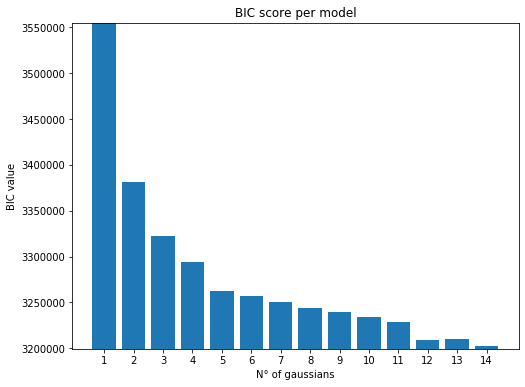

In [19]:
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)

for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components = n_components,
                                  covariance_type = 'full', 
                                  max_iter=100, 
                                  init_params='kmeans',
                                  random_state=0)
    gmm.fit(X)
    bic.append(gmm.bic(X))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
        
bic = np.array(bic)

clf = best_gmm

bars = []

# Plot the BIC scores
plt.figure(figsize=(8, 6))
plt.bar(x=n_components_range, height=bic)
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
plt.ylabel('BIC value')
plt.xlabel('N° of gaussians')

plt.show()

Se prueba con los 12 clusters sugeridos por BIC, pero el resultado es (como se esperaba) una sobredivición del cuerpo del paciente. Se decide seguir el mismo criterio aplicado antes y usar 2 clusters.

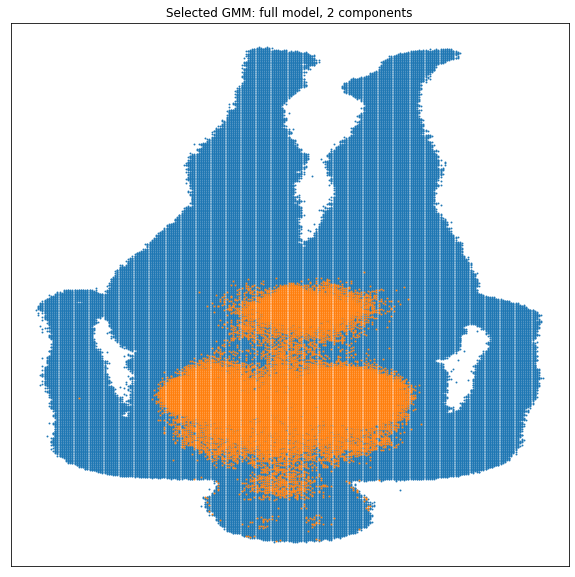

In [42]:
clf = mixture.GaussianMixture(n_components=2,
                              covariance_type = 'full', 
                              init_params='kmeans',
                              random_state=0)
Y_=clf.fit_predict(X)

# Plot the winner
plt.figure(figsize=(10,10))
for i in np.unique(Y_.astype('int')):
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, cmap=plt.get_cmap('Set3'))

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.show()

Se puede ver que el resultado obtenido es muy interesante. Permite identificar toda la región central, justamente en el trabajo previo logramos por medio de los outliers en las imágenes de tiempos posteriores identificar regiones muy similares, en donde pareceieran tener presencia los pulmones los uréteres, la columna vertebral.

Se decide por quedarnos con esa porcion de los datos y volver a aplicar el algoritmo.

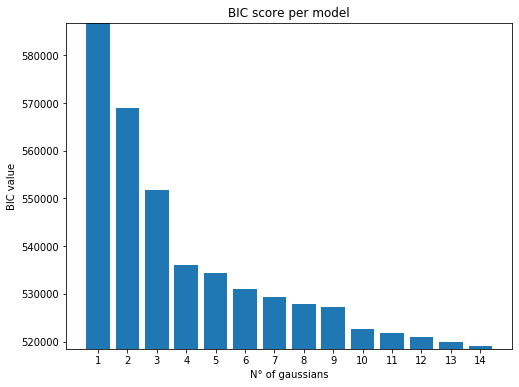

In [35]:
X2 = X[Y_ == 1,:]
lowest_bic = np.infty
bic = []
n_components_range = range(1, 15)

for n_components in n_components_range:
    # Fit a Gaussian mixture with EM
    gmm = mixture.GaussianMixture(n_components = n_components,
                                  covariance_type = 'full', 
                                  max_iter=100, 
                                  init_params='kmeans',
                                  random_state=0)
    gmm.fit(X2)
    bic.append(gmm.bic(X2))
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_gmm = gmm
        
bic = np.array(bic)

clf = best_gmm

bars = []

# Plot the BIC scores
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
plt.figure(figsize=(8, 6))
plt.bar(x=n_components_range, height=bic)
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
plt.ylabel('BIC value')
plt.xlabel('N° of gaussians')

plt.show()

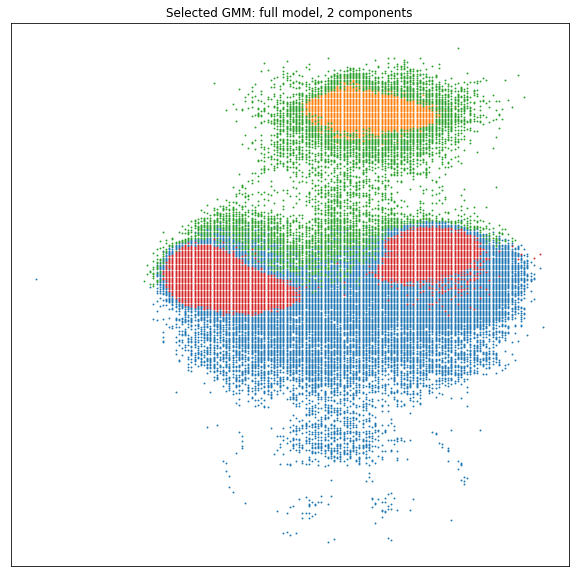

In [41]:
clf = mixture.GaussianMixture(n_components=4,
                              covariance_type = 'full', 
                              init_params='kmeans',
                              random_state=0)
Y2_=clf.fit_predict(X2)

# Plot the winner
plt.figure(figsize=(10,10))
for i in np.unique(Y2_.astype('int')):
    plt.scatter(X2[Y2_ == i, 0], X2[Y2_ == i, 1], .8, cmap=plt.get_cmap('Set3'))

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.show()

En la imagen se logra apreciar, cómo el algoritmo logra identificar los dos órganos como el mismo cluster (consecuente con nuestro trabajo previo), la vejiga como un elemento distinto, y finalmente todo un grupo de pixeles que se podrían corresponder con el tejido periférico a los órganos que emite con una intersidad mayor a la del resto del cuerpo, pero que no es el blanco concreto del radiofármaco.

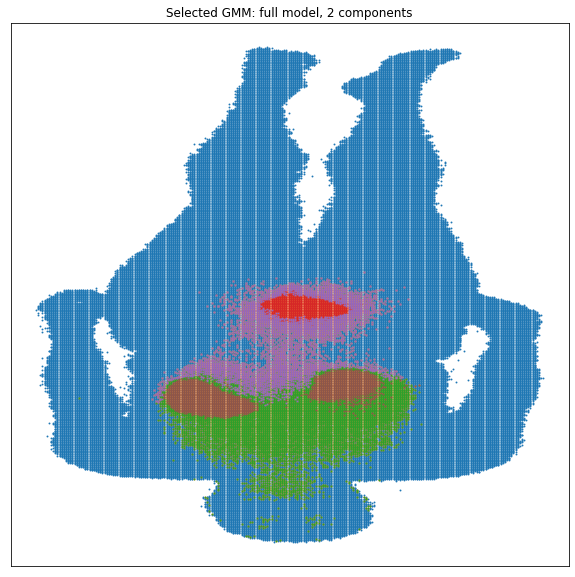

In [44]:
# Plot the winner
plt.figure(figsize=(10,10))
for i in np.unique(Y_.astype('int')):
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, cmap=plt.get_cmap('Dark2'))
for i in np.unique(Y2_.astype('int')):
    plt.scatter(X2[Y2_ == i, 0], X2[Y2_ == i, 1], .8, cmap=plt.get_cmap('Set3'))

plt.xticks(())
plt.yticks(())
plt.title('Selected GMM: full model, 2 components')
plt.show()